In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.ndvi import get_yard_data, calculate_ndvi, process_image

import warnings
warnings.filterwarnings("ignore")

In [2]:
### Load data and process the images 
years = [2020, 2022, 2023]
results = []
for count, year in enumerate(years):
    # load the aerial images and get the geo bounds
    input_aerial_rgb = f'data/{year}_breda_rgb_small.tif'
    input_aerial_cir = f'data/{year}_breda_cir_small.tif'
    aeriel_rgb = rasterio.open(input_aerial_rgb)
    aeriel_cir = rasterio.open(input_aerial_cir)
    if count > 0:
        assert aeriel_cir.bounds == bounds, "The bounds of the images are not the same over the years"
    bounds = tuple(aeriel_cir.bounds)
    if count == 0:
        largest_overlap = get_yard_data(bounds)
    results.append(process_image(largest_overlap, aeriel_rgb, aeriel_cir))

Status: PENDING. Waiting...
Download ready: /kadaster/kadastralekaart/download/v5_0/extract/0761202d-1275-4461-9706-37e0e65e63fe/extract.zip
Downloaded file saved to kadaaster_data.zip
Extracted files to kadaaster_data


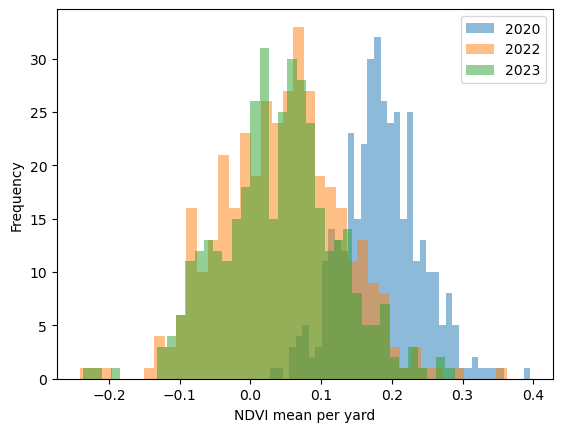

In [3]:
# make a ndvi histogram
for count, df in enumerate(results):
    plt.hist(df['ndvi_mean'], bins=40, alpha=0.5, label=years[count])
    plt.xlabel('NDVI mean per yard')
    plt.ylabel('Frequency')
plt.legend()

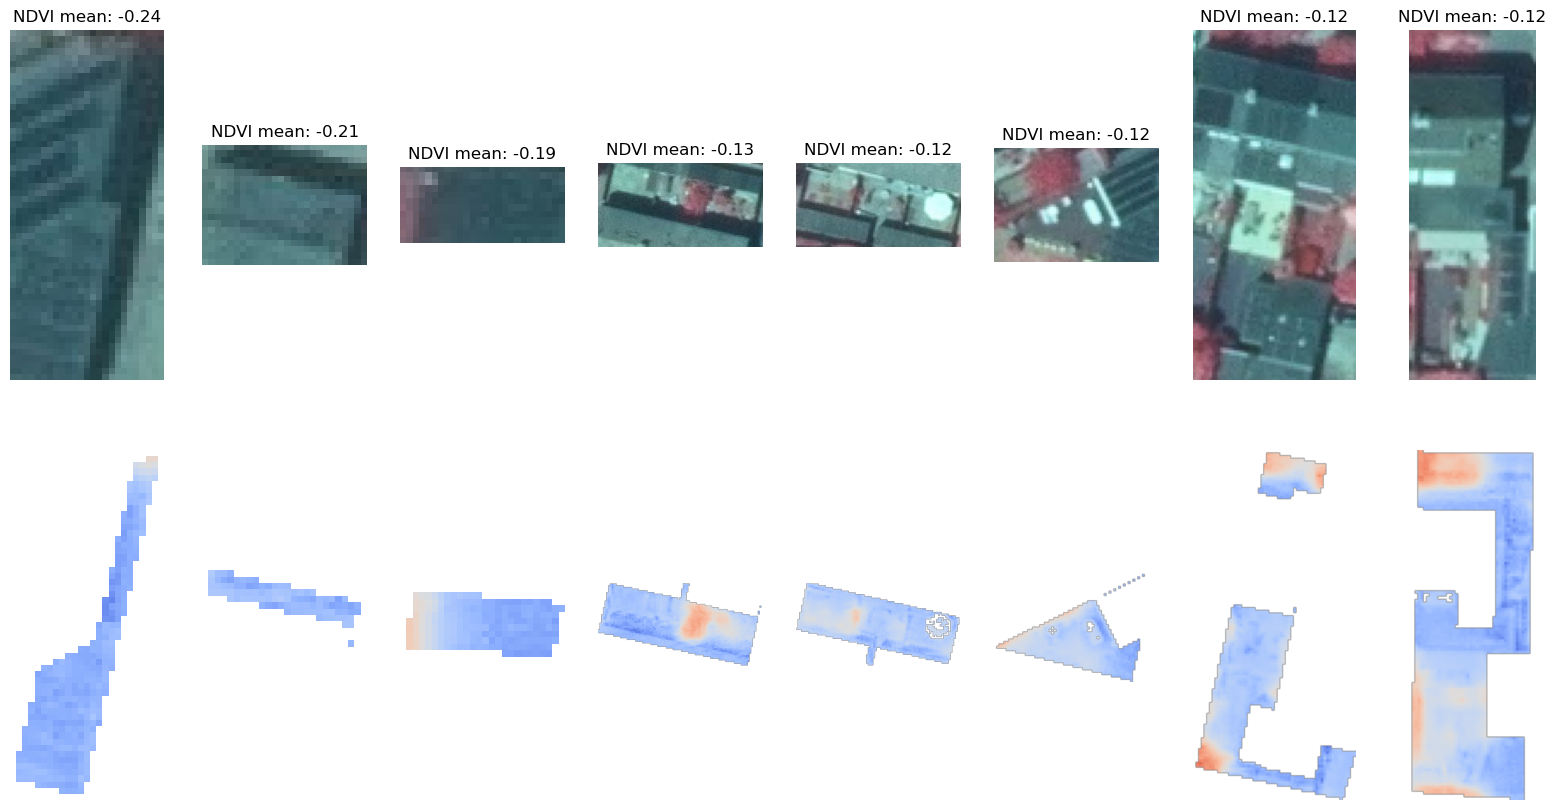

In [4]:
# plot top 8 plots with lowest NDVI mean and directly below that plot the correspondig NDVI map
top5 = df.sort_values(by='ndvi_mean').head(8)
fig, ax = plt.subplots(2, 8, figsize=(20, 10))
for i, (_, row) in enumerate(top5.iterrows()):
    ax[0, i].imshow(row['clipped_cir'].transpose((1, 2, 0)))
    ax[0, i].set_title(f"NDVI mean: {row['ndvi_mean']:.2f}")
    ax[0, i].axis('off')
    ax[1, i].imshow(row['ndvi'], cmap='coolwarm', vmin=-0.5, vmax=0.5)
    ax[1, i].axis('off')
plt.show()

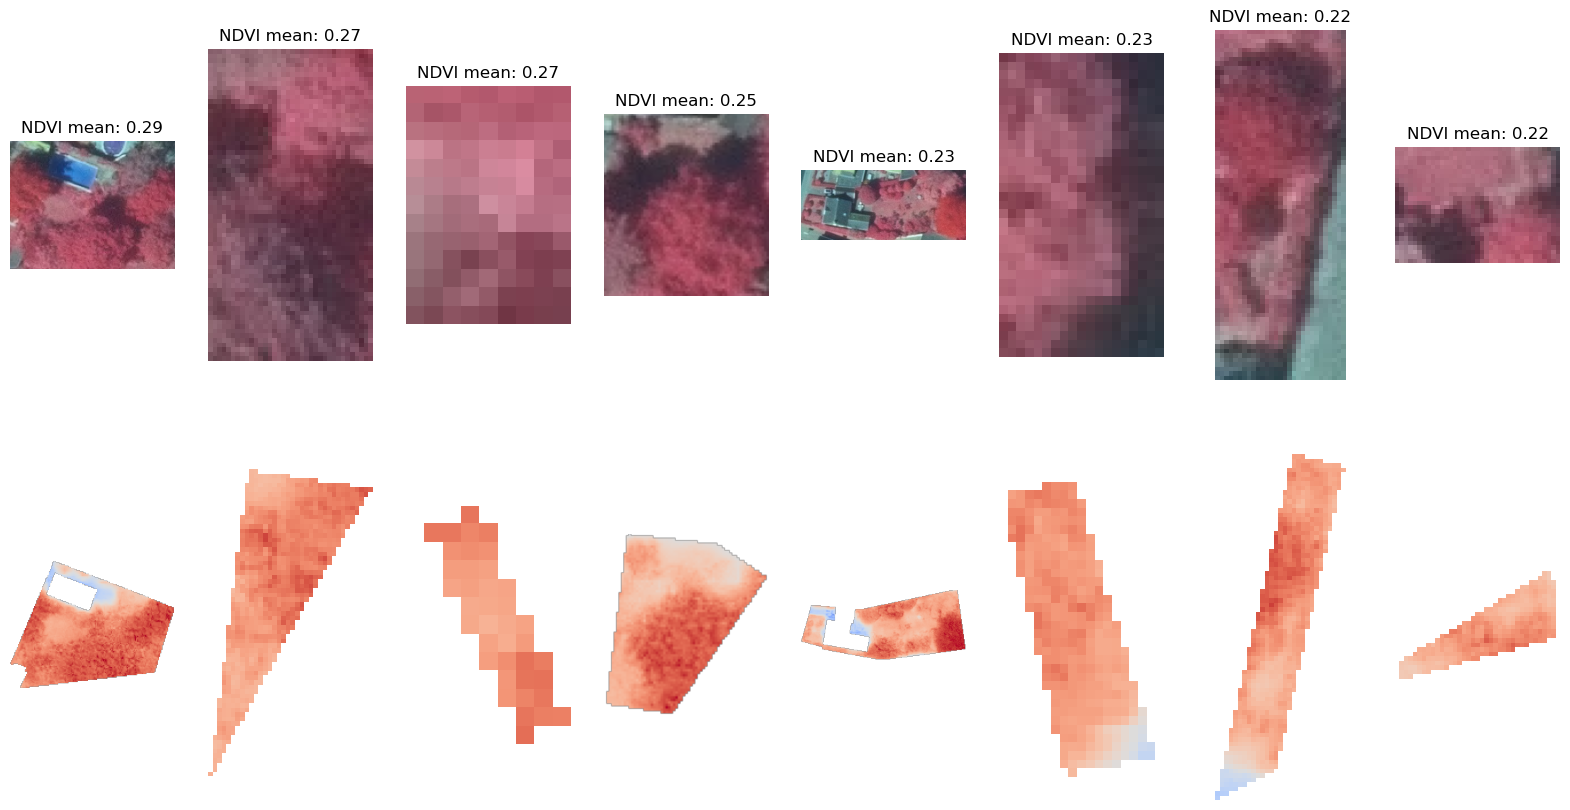

In [5]:
# plot top 5 plots with highest NDVI mean and directly below that plot the correspondig NDVI map
top5 = df.nlargest(8, 'ndvi_mean')
fig, ax = plt.subplots(2, 8, figsize=(20, 10))
for i, (_, row) in enumerate(top5.iterrows()):
    ax[0, i].imshow(row['clipped_cir'].transpose((1, 2, 0)))
    ax[0, i].set_title(f"NDVI mean: {row['ndvi_mean']:.2f}")
    ax[0, i].axis('off')
    ax[1, i].imshow(row['ndvi'], cmap='coolwarm', vmin=-0.5, vmax=0.5)
    ax[1, i].axis('off')
plt.show()

NL.IMKAD.KadastraalObject.6950466670000


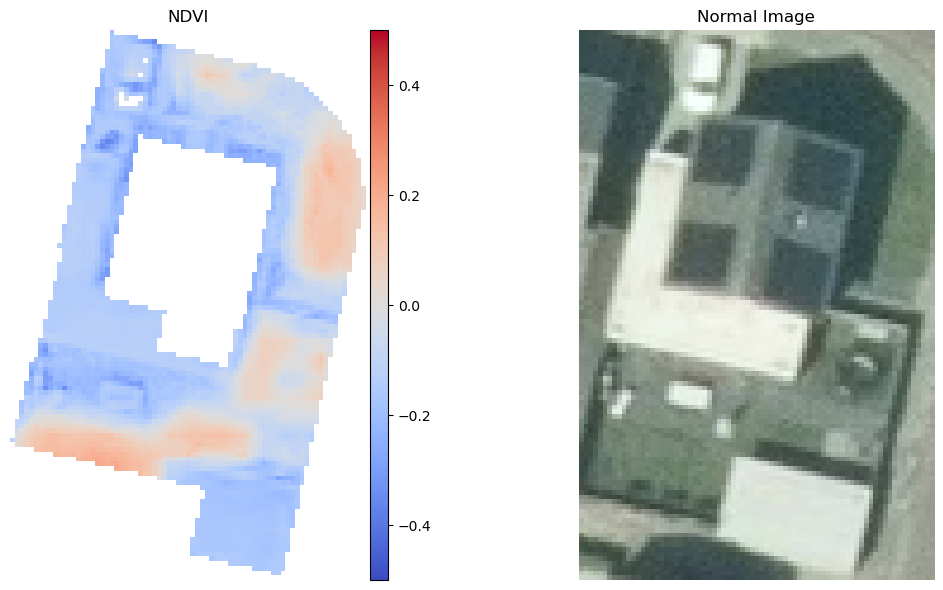

NL.IMKAD.KadastraalObject.6950423570000


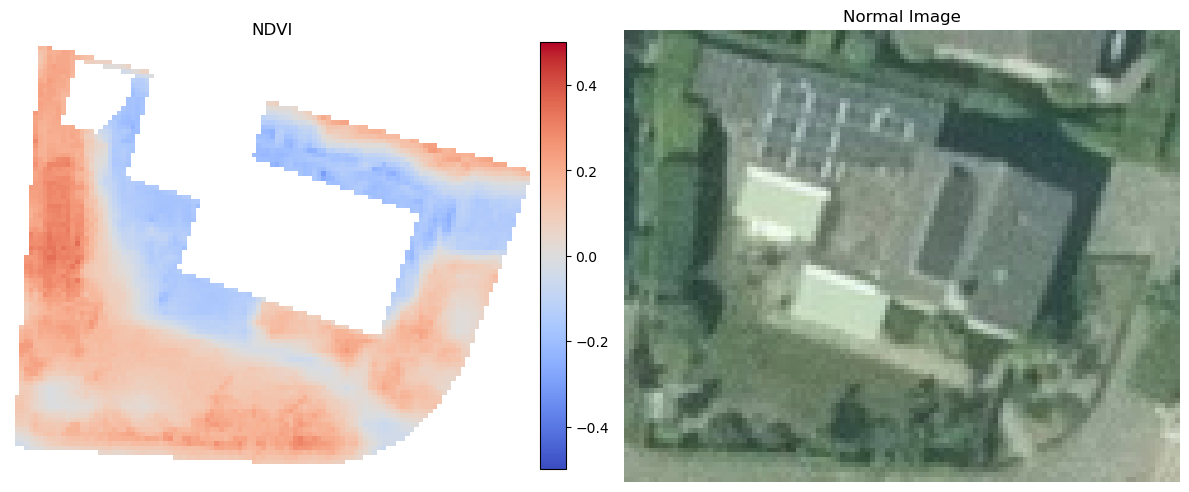

NL.IMKAD.KadastraalObject.6950636770000


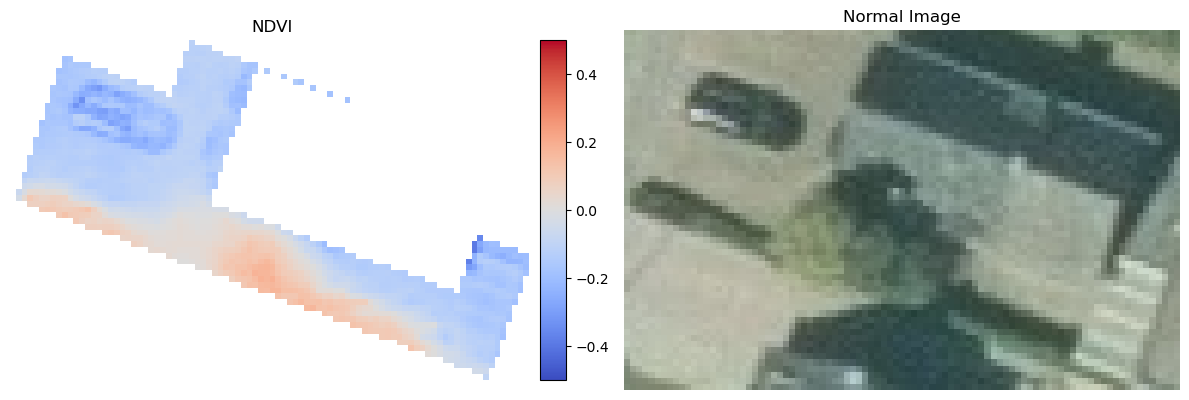

NL.IMKAD.KadastraalObject.6950566870000


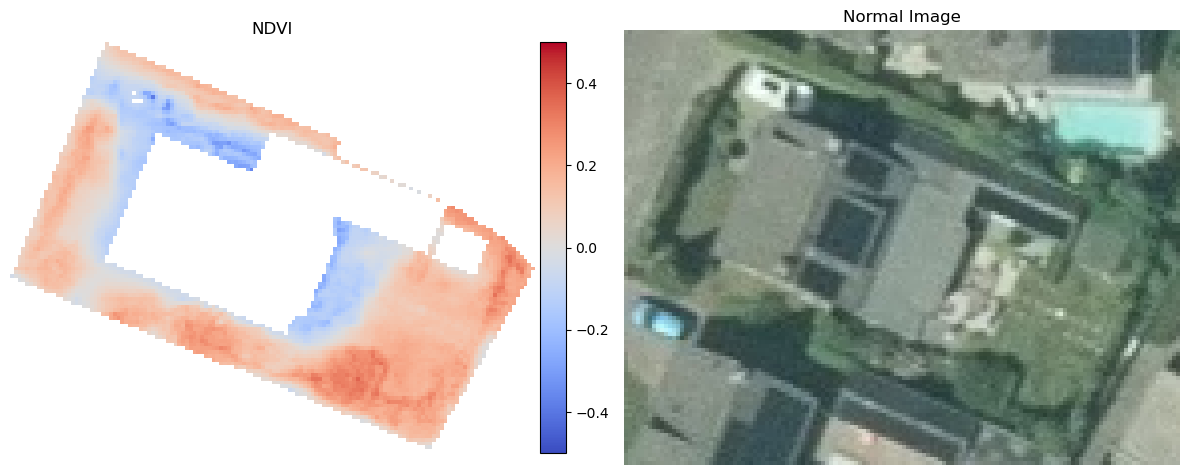

NL.IMKAD.KadastraalObject.6950400770000


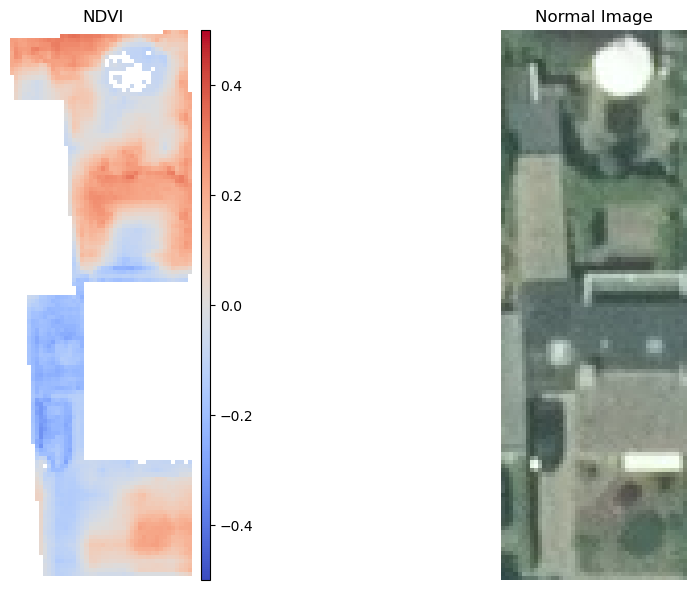

NL.IMKAD.KadastraalObject.6950398170000


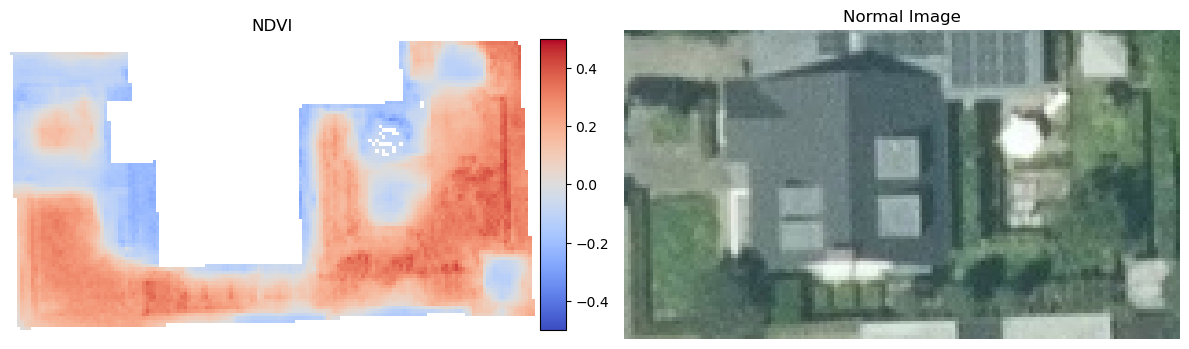

NL.IMKAD.KadastraalObject.6950408470000


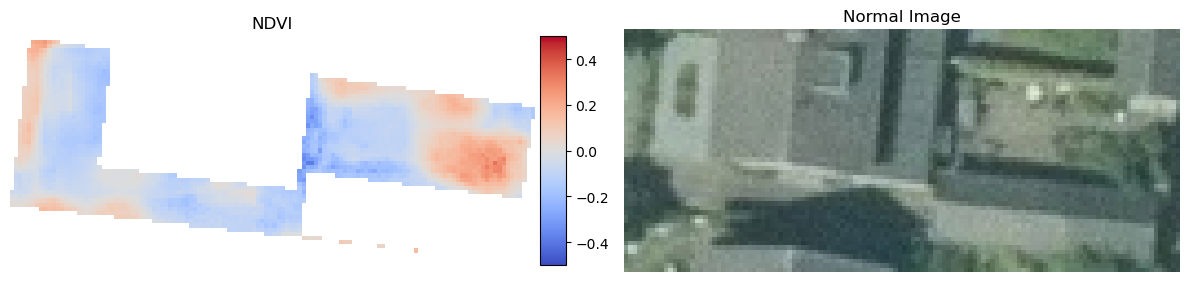

NL.IMKAD.KadastraalObject.6950374870000


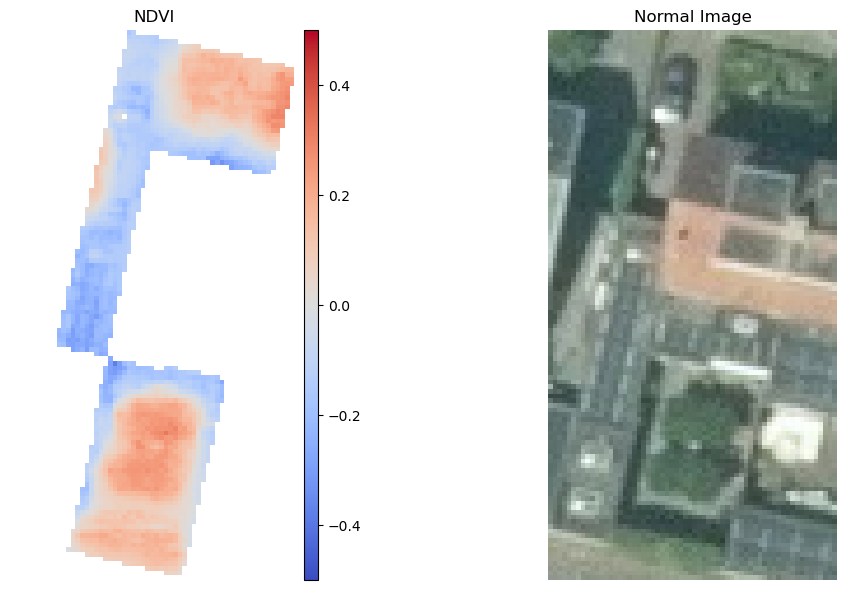

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plot a couple of random erf's
for row in df.sample(8).iterrows():
    plot_name = row[0]
    zone_im = row[1].clipped_cir
    zone_im_rgb = row[1].clipped_rgb
    print(plot_name)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ndvi = calculate_ndvi(zone_im)

    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    im1 = axes[0].imshow(ndvi, cmap='coolwarm', vmin=-0.5, vmax=0.5)
    axes[0].set_title('NDVI')
    axes[0].axis('off')
    fig.colorbar(im1, cax=cax, orientation='vertical')

    axes[1].imshow(np.transpose(zone_im_rgb[:3], axes=(1, 2, 0)))
    axes[1].set_title('Normal Image')
    axes[1].axis('off')

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    plt.tight_layout()
    plt.show()

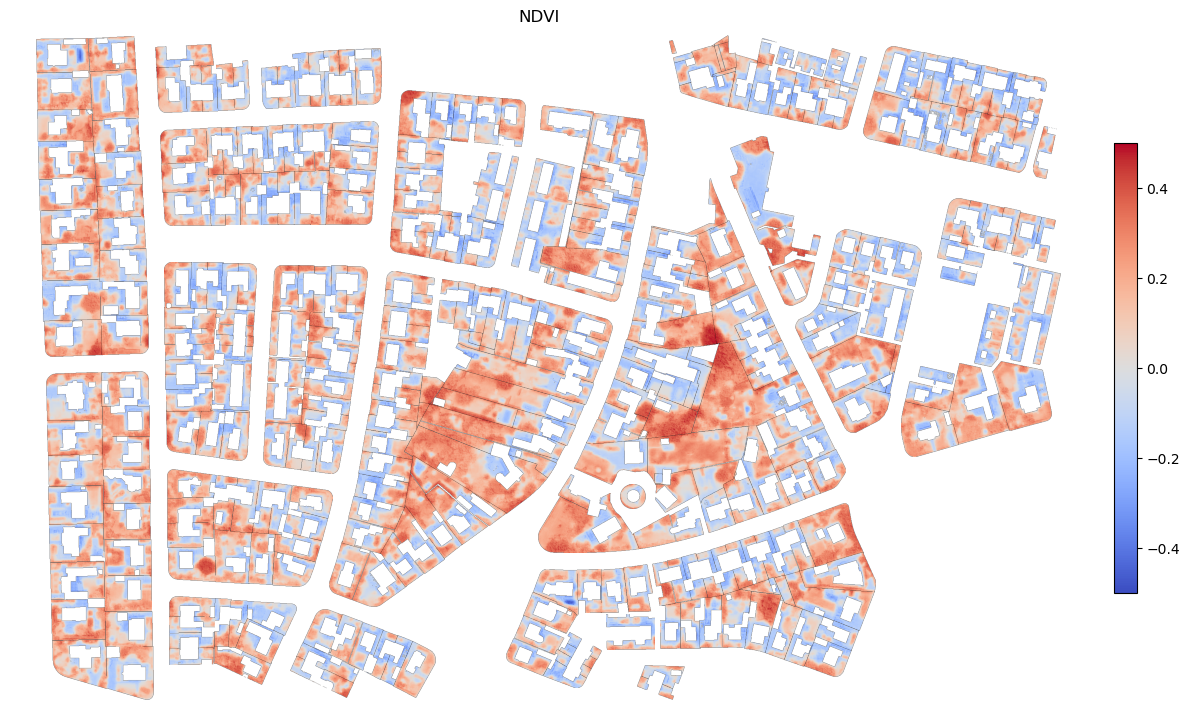

In [7]:
from rasterio.plot import show
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

norm = Normalize(vmin=-0.5, vmax=0.5)  # Set the same vmin and vmax as in the plot
cmap = 'coolwarm'  # Same colormap as in the plot

fig, ax = plt.subplots(figsize=(12, 12))

for row in df.iterrows():
    plot_name = row[0]
    clipped_cir = row[1].clipped_cir
    clipped_rgb = row[1].clipped_rgb
    transform = row[1].affine_transform
    ndvi = row[1].ndvi
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Plot the CIR raster
    show(
        ndvi,
        transform=transform,
        ax=ax,
        title="Combined Plot of Clipped Zones",
        cmap=cmap,  # Use a color map
        vmin=-0.5,
        vmax=0.5,
    )

# Set labels and titles
plt.xlabel("Longitude")
sm = ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
plt.xlim(bounds[0], bounds[2])
plt.ylim(bounds[1], bounds[3])
plt.ylabel("Latitude")
plt.title("NDVI")
plt.axis("off")
plt.tight_layout()
plt.show()

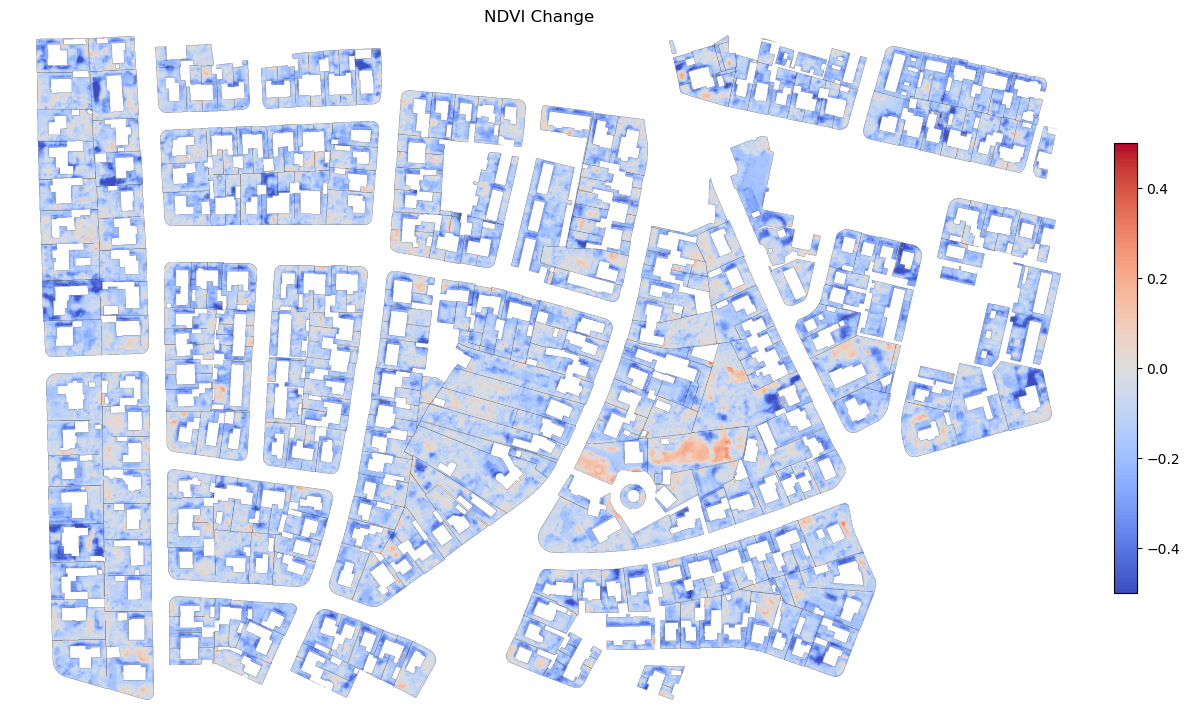

In [9]:
# plot difference

fig, ax = plt.subplots(figsize=(12, 12))

df1 = results[0]
df2 = results[-1]

for row in df1.iterrows():
    plot_name = row[0]
    clipped_cir = row[1].clipped_cir
    clipped_rgb = row[1].clipped_rgb
    transform = row[1].affine_transform
    ndvi1 = row[1].ndvi
    ndvi2 = df2.loc[plot_name]['ndvi']
    ndvi = ndvi2 - ndvi1
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Plot the CIR raster
    show(
        ndvi,
        transform=transform,
        ax=ax,
        title="Combined Plot of Clipped Zones",
        cmap=cmap,  # Use a color map
        vmin=-0.5,
        vmax=0.5,
    )

# Set labels and titles
plt.xlabel("Longitude")
sm = ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
plt.xlim(bounds[0], bounds[2])
plt.ylim(bounds[1], bounds[3])
plt.ylabel("Latitude")
plt.title("NDVI Change")
plt.axis("off")
plt.tight_layout()
plt.show()